# Using multi-output model to classify Delhi Weather Data
Task: predict 4 weather metrics into the future - mean temperature, humidity, wind speed and mean pressure - and classify comfort (comfortable = 1, not comfortable = 0)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import keras_tuner as kt

## Process train and test data

In [2]:
train = pd.read_csv('C:/Users/mandy/OneDrive/2022 IRS/ML/Datasets/Delhi Climate/DailyDelhiClimateTrain.csv')
train = train.drop('date', axis=1)
train.shape

(1462, 5)

In [3]:
test = pd.read_csv('C:/Users/mandy/OneDrive/2022 IRS/ML/Datasets/Delhi Climate/DailyDelhiClimateTest.csv')
test = test.drop('date', axis=1)
test.shape

(114, 5)

In [5]:
def normalise(data, min, max):
    data = data - min
    data = data / max
    return data

for col in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
    train_data = train[col].values
    train[col] = normalise(train_data, train_data.min(axis=0), train_data.max(axis=0))
    test_data = test[col].values
    test[col] = normalise(test_data, train_data.min(axis=0), train_data.max(axis=0))

print(train.describe())
print()
print(test.describe())

          meantemp     humidity   wind_speed  meanpressure  comfortable
count  1462.000000  1462.000000  1462.000000   1462.000000  1462.000000
mean      0.595933     0.473431     0.161113      0.132062     0.219562
std       0.224614     0.167697     0.108044      0.023470     0.414092
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%       0.393013     0.369464     0.082307      0.130822     0.000000
50%       0.663755     0.491964     0.147363      0.131731     0.000000
75%       0.773540     0.587902     0.218812      0.132562     0.000000
max       1.000000     0.865714     1.000000      1.000396     1.000000

         meantemp    humidity  wind_speed  meanpressure  comfortable
count  114.000000  114.000000  114.000000    114.000000   114.000000
mean    25.695390    0.428298    0.192893      0.131141     0.236842
std      7.526548    0.190681    0.084985      0.011651     0.427022
min     13.017467    0.043214    0.032864      0.008079     0.000000
25%   

## Plot train data

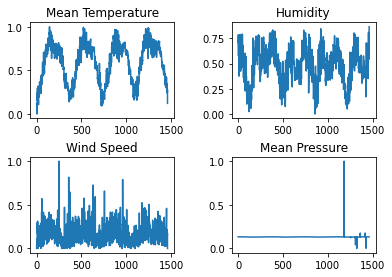

In [6]:
fig, ax = plt.subplots(2, 2)
# fig.suptitle('Delhi Weather Features')
ax[0, 0].plot(range(len(train['meantemp'])), train['meantemp'])
ax[0, 0].set_title('Mean Temperature')
ax[0, 1].plot(range(len(train['humidity'])), train['humidity'])
ax[0, 1].set_title('Humidity')
ax[1, 0].plot(range(len(train['wind_speed'])), train['wind_speed'])
ax[1, 0].set_title('Wind Speed')
ax[1, 1].plot(range(len(train['meanpressure'])), train['meanpressure'])
ax[1, 1].set_title('Mean Pressure')

plt.subplots_adjust(left = 0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Create features and labels

In [7]:
def windowed_dataset(series, n_past, n_future, batch_size, shift=1):

    # n_past = number of timesteps to look back (x or input to model)
    # n_future = number of timesteps to predict (y or output of model)

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future)) # flat_map returns a non-iterable, unlike map which returns a list
    dataset = dataset.map(lambda window: (window[:n_past, :4], (window[:n_past, :4], window[n_past:, 4])))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

batch_size = 32 # affects performance, but impact is not straightforward (i.e. larger batch_size =/= better performance)
n_past = 10
n_future = 10
shift = 1

test_ds = windowed_dataset(series=test[['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'comfortable']].values, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
train_ds = windowed_dataset(series=train[['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'comfortable']].values, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)

In [8]:
def windowed_dataset_structure(dataset):
    for x, (p, c) in dataset:
        print(np.array(x).shape, [np.array(p).shape, np.array(c).shape])

windowed_dataset_structure(test_ds)
print()
windowed_dataset_structure(train_ds)

(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(31, 10, 4) [(31, 10, 4), (31, 10)]

(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (32, 10)]
(32, 10, 4) [(32, 10, 4), (

## Build Model

In [25]:
xIn = Input((n_past, 4))
x = LSTM(64, return_sequences=True)(xIn) # set return_sequences = True if there's an LSTM layer afterwards
x = LSTM(64, return_sequences=True)(x)

x = Dense(64, activation='swish')(x)
x = Dense(64, activation='swish')(x)

# meantemp_output = Dense(n_future, activation='swish', name='meantemp_output')(x)

# humidity_output = Dense(n_future, activation='swish', name='humidity_output')(x)

# wind_speed_output = Dense(n_future, activation='swish', name='wind_speed_output')(x)

# meanpressure_output = Dense(n_future, activation='swish', name='meanpressure_output')(x)

weather_output = Dense(n_future, activation='swish', name='weather_output')(x)

x = Dense(64, activation='swish')(weather_output)
x = Flatten()(x)
comfort_output = Dense(n_future, activation='sigmoid', name='comfort_output')(x)

model = Model(inputs=xIn, outputs=[weather_output, comfort_output])
model.compile(optimizer='adam', 
              loss={
                  'weather_output': 'mse', 
                  'comfort_output': 'binary_crossentropy'},
              metrics={
                  'weather_output': 'mse', 
                  'comfort_output': 'accuracy'})
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 64)            17664     
                                                                 
 lstm_17 (LSTM)              (None, 10, 64)            33024     
                                                                 
 dense_24 (Dense)            (None, 10, 64)            4160      
                                                                 
 dense_25 (Dense)            (None, 10, 64)            4160      
                                                                 
 weather_output (Dense)      (None, 10, 10)            650       
                                                                 
 dense_26 (Dense)            (None, 10, 64)            704 

In [ ]:
# xIn = Input((n_past, 5))
# x = LSTM(64, return_sequences=True)(xIn) # set return_sequences = True if there's an LSTM layer afterwards
# x = LSTM(64)(x)
# x = Flatten()(x) # alternative: GlobalAvgPool2D() - may lose some accuracy, but smaller output shape than Flatten()

# x = Dense(64, activation='swish')(x)
# x = Dense(64, activation='swish')(x)

# meantemp_output = Dense(1, activation='swish', name='meantemp_output')(x)

# humidity_output = Dense(1, activation='swish', name='humidity_output')(x)

# wind_speed_output = Dense(1, activation='swish', name='wind_speed_output')(x)

# meanpressure_output = Dense(1, activation='swish', name='meanpressure_output')(x)

# comfort_output = Dense(1, activation='sigmoid', name='comfort_output')(x)

# xOut = Concatenate()([meantemp_output, humidity_output, wind_speed_output, meanpressure_output, comfort_output])

# model = Model(inputs=xIn, outputs=xOut)
# model.compile(optimizer='adam', 
#               loss={
#                   'meantemp_output': 'mse', 
#                   'humidity_output': 'mse', 
#                   'wind_speed_output': 'mse', 
#                   'meanpressure_output': 'mse', 
#                   'comfort_output': 'binary_crossentropy'},
#               metrics={
#                   'meantemp_output': 'mse', 
#                   'humidity_output': 'mse', 
#                   'wind_speed_output': 'mse', 
#                   'meanpressure_output': 'mse', 
#                   'comfort_output': 'accuracy'})
# model.summary()

In [26]:
epochs = 30

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./7_best_model', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='mse', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='mse', factor=0.1, patience=3, verbose=1)
]

history = model.fit(train_ds, validation_data=test_ds, batch_size=32, epochs=epochs, callbacks=callbacks)

Epoch 1/30


ValueError: in user code:

    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\mandy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 10 and 4 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_8/weather_output/IdentityN, Cast)' with input shapes: [?,10,10], [?,?,4].


## Plot accuracy and loss

In [ ]:
plt.plot(history.history['meantemp_output_mean_squared_error'], label='Mean Temp Train MSE')
plt.plot(history.history['val_meantemp_output_mean_squared_error'], label='Mean Temp Val MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['humidity_output_mean_squared_error'], label='Humidity Train MSE')
plt.plot(history.history['val_humidity_output_mean_squared_error'], label='Humidity Val MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['wind_speed_output_mean_squared_error'], label='Wind Speed Train MSE')
plt.plot(history.history['val_wind_speed_output_mean_squared_error'], label='Wind Speed Val MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['meanpressure_output_mean_squared_error'], label='Mean Pressure Train MSE')
plt.plot(history.history['val_meanpressure_output_mean_squared_error'], label='Mean Pressure Val MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['comfort_output_acc'], label='Comfort Train Accuracy')
plt.plot(history.history['val_meantemp_output_acc'], label='Comfort Val Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()